## RL Assignment - Track 1 (Dyna Q)

** Name :** Shruti Bhanderi

**McGill ID:** 260724575



In [8]:
! pip install git+https://github.com/deepmind/pycolab.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-96zv8lbb-build


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import curses
import sys

from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites
import matplotlib.pyplot as plt
import numpy as np



GAME_ART = [['###########',
             '#         #',
             '#         #',
             '#         #',
             '######### #',
             '#         #',
             '#   P     #',
             '###########'],
            ['###########',
             '#         #',
             '#         #',
             '#         #',
             '# #########',
             '#         #',
             '#   P     #',
             '###########'],
            ['###########',
             '#         #',
             '#         #',
             '#         #',
             '# ####### #',
             '#         #',
             '#   P     #',
             '###########'],
            ]


ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT ,ACTION_RIGHT]
maxSteps=3000


In [0]:
#################Pycolab functions overriding######################################


def make_game(maze):
    return ascii_art.ascii_art_to_game(maze,what_lies_beneath=' ', sprites={'P':PlayerSprite})

class PlayerSprite(prefab_sprites.MazeWalker):

    def __init__(self,corner,position,character):
        super(PlayerSprite,self).__init__(corner,position,character,impassable='#')

    def update(self,actions,board,layers,backdrop,things,the_plot):
        del layers,backdrop,things

        if actions ==0:
            the_plot.add_reward(0.0)
            self._north(board,the_plot)
        elif actions ==1:
            the_plot.add_reward(0.0)
            self._south(board,the_plot)
        elif actions ==2:
            the_plot.add_reward(0.0)
            self._west(board,the_plot)
        elif actions ==3:
            the_plot.add_reward(0.0)
            self._east(board,the_plot)

        if self.position ==(1,9):
            the_plot.add_reward(1.0)

        if (actions == -1):
            self._teleport((6,4))  # we should go back to start position when we reach goal.





 >**Dyna-Q (Sutton & Barto)**

---

Loop:
1. $S \leftarrow$  current_state
2. $A \leftarrow$ epsilon-greedy $(S,Q)$
3. Take action $A$; observe resultant reward,$R$, and state $S'$
4. $Q$-learning update : $Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma * max_a Q(S',a) - Q(S,A)]$
5. Deterministic Environment : $Model(S,A) \leftarrow R,S'$
6. Loop $n$ times:
   * $S \leftarrow$  random previously observed state
   * $A \leftarrow$  random action previously taken in S
   * $R,S' \leftarrow$ Model(S,A)
   * $Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma * max_a Q(S',a) - Q(S,A)]$
  

In [0]:
# DynaQ implementation


# Dyna Q and Dyna Q+ - this will be called for each episode,
def dynaQ(stateActionValues,maze,params,game,model):
    # Steps 1: defining S (Sutton & Barto)
    currentState=(6,4)
    steps=0
    while (currentState!=(1,9)):
        steps+=1

        # Steps 2: epsilon greedy algo - choosing action (Sutton & Barto)
        action = epsilonGreedy(currentState,stateActionValues,params)

        # Steps 3: playing action (Sutton & Barto)- returning observations(state) and reward
        obs,reward,gamma = game.play(action)
        newpositions =np.array(obs.layers['P'],dtype=np.float)
        newState = np.where(newpositions ==1)            #state returned S'

        # Steps 4: Q-learning update step (Sutton & Barto)- formula
        stateActionValues[currentState[0],currentState[1],action]+=params.alpha * (reward + params.gamma * np.max(stateActionValues[newState[0], newState[1], :]) -stateActionValues[currentState[0], currentState[1], action])

        # Steps 5: training our model with experience (assuming deterministic environment) (Sutton & Barto)
        model.train(currentState, action, newState, reward)

        # Step 6: sampling experience from above model (Sutton & Barto)
        for t in range(0, params.planningSteps):
            # 6a) random previously observed state,6b) action and 6c) Model update
            stateSample, actionSample, newStateSample, rewardSample = model.sample()
            #6c) Q-learning update step planning
            stateActionValues[stateSample[0], stateSample[1], actionSample] += \
                params.alpha * (rewardSample + params.gamma * np.max(stateActionValues[newStateSample[0], newStateSample[1], :]) -
                stateActionValues[stateSample[0], stateSample[1], actionSample])
        currentState=(newState[0][0],newState[1][0])
        #print(currentState)
        if steps >maxSteps:
            break

    #if goal reached, go back to start position, action -1 will bring it back to start.
    if (currentState == (1,9)):
        game.play(-1)

    return steps

class AllParameters:

    def __init__(self):
        self.gamma = 0.95
        self.epsilon = 0.1
        self.alpha = 0.1
        self.kappa = 1e-4
        self.planningSteps = 5
        self.runs = 10
        self.theta = 0
        # algorithm names
        self.methods = ['Dyna-Q', 'Dyna-Q+']

        
# Select action based on epsilon-greeedy algorithm, returns action - 0,1,2,3
def epsilonGreedy(state,stateActionValues,params):
    if np.random.binomial(1,params.epsilon) ==1:
        return np.random.choice(actions)
    else:
        values = stateActionValues[state[0],state[1],:]
        choices=[]
        for action,value in enumerate(values):
            if value==np.max(values):
                choices.append(action)

        choosen_value=np.random.choice(choices)
        return choosen_value


# Simple model for planning in Dyna-Q
class SimpleModel:

    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # train the model with previous experience
    def train(self, currentState, action, newState, reward):
        if tuple(currentState) not in self.model.keys():
            self.model[tuple(currentState)] = dict()
        self.model[tuple(currentState)][action] = [list(newState), reward]

    # randomly sample from previous experience
    def sample(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        state = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[state].keys())))
        action = list(self.model[state])[actionIndex]
        newState, reward = self.model[state][action]
        return list(state), action, list(newState), reward

# Planning with Time-based model -  Dyna-Q+
class TimeModel:
     # @kappa: the weight for elapsed time in sampling reward, will be very small
    def __init__(self, maze, kappa=1e-4, rand=np.random):
        self.rand = rand
        self.model = dict()
        self.kappa = kappa
        self.time = 0       # tracking time

        self.maze = maze

    # training our model with past experience
    def train(self, currentState, action, newState, reward):
        self.time += 1
        if tuple(currentState) not in self.model.keys():
            self.model[tuple(currentState)] = dict()

            # Those actions should be allowed to be considered in the planning which had never been tried before from a state
            for action_ in actions:
                if action_ != action:
                    # these actions will get us back to same state with  reward = zero
                    self.model[tuple(currentState)][action_] = [list(currentState), 0, 1]

        self.model[tuple(currentState)][action] = [list(newState), reward, self.time]

    # random sampling from past experience
    def sample(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        state = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[state].keys())))
        action = list(self.model[state])[actionIndex]
        newState, reward, time = self.model[state][action]

        # we shpuld adjust reward - page 136 formula - r+ kappa *sqrt(time difference tau)
        reward += self.kappa * np.sqrt(self.time - time)

        return list(state), action, list(newState), reward



In [0]:

def blockingMAZE():
    # initializing dynaQ parameters
    params = AllParameters()

    # trying other alpha
    params.alpha = 0.7

    # averaging over 15 runs
    params.runs = 20

    # stateaction value defining with the maze size(fixed)
    sAV = np.zeros((8, 11, len(actions)))

    # 2 - one for DynaQ and other for DynaQ+
    rewards = np.zeros((2, maxSteps))

    # Running and averaging over runs
    for run in range(0, params.runs):

        # cumulative reward in this run (both Dyna Q and Dyna Q+)
        rewards_ = np.zeros((2, maxSteps))

        # initialize stateaction values for this run. All zero.
        stateActionValues = [np.copy(sAV), np.copy(sAV)]

        # Dyna Q and Dyna Q+ methods
        for i in range(0, len(params.methods)):

            # Blocking maze pattern 1
            game = make_game(GAME_ART[0])
            obs, reward, gamma = game.its_showtime()
            # MAZE is here!
            maze = np.array(obs.layers['P'], dtype=np.float)

            # models will be used in DynaQ and DynaQ+
            models = [SimpleModel(), TimeModel(maze, kappa=params.kappa)]

            steps = 0
            flag = 0
            lastSteps = steps
            while steps < 3000:
                steps += dynaQ(stateActionValues[i], maze, params, game, models[i])
                steps_ = min(steps, maxSteps - 1)
                rewards_[i, lastSteps: steps_] = rewards_[i, lastSteps]
                rewards_[i, steps_] = rewards_[i, lastSteps] + 1
                lastSteps = steps

                # Change MAZE pattern (Blocking Maze) after 1000 steps
                if (steps / 1000 > 1) & (flag == 0):
                    flag = 1
                    game = make_game(GAME_ART[1])
                    obs, reward, gamma = game.its_showtime()
                    maze = np.array(obs.layers['P'], dtype=np.float)

        rewards += rewards_
    # averaging over runs
    rewards /= params.runs
    print(rewards)

    # Plot for average performance of Dyna agents on a blocking task.
    plt.figure(1)
    for i in range(0, len(params.methods)):
        plt.plot(range(0, maxSteps), rewards[i, :], label=params.methods[i])
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Rewards')
    plt.title('Blocking MAZE')
    plt.legend()
    plt.show()
    return

def shortcutMAZE():
    # initializing dynaQ parameters
    maxSteps=6000
    params = AllParameters()

    # trying other alpha
    params.alpha = 0.7

    # averaging over 5 runs
    params.runs = 5

    # kappa must be small, as the reward for getting the goal is only 1
    params.kappa = 1e-3
    params.planningSteps = 50

    # stateaction value defining with the maze size(fixed)
    sAV = np.zeros((8, 11, len(actions)))

    # 2 - one for DynaQ and other for DynaQ+
    rewards = np.zeros((2, maxSteps))

    # Running and averaging over runs
    for run in range(0, params.runs):

        # cumulative reward in this run (both Dyna Q and Dyna Q+)
        rewards_ = np.zeros((2, maxSteps))

        # initialize stateaction values for this run. All zero.
        stateActionValues = [np.copy(sAV), np.copy(sAV)]

        # Dyna Q and Dyna Q+ methods
        for i in range(0, len(params.methods)):

            # Blocking maze pattern 1
            game = make_game(GAME_ART[1])
            obs, reward, gamma = game.its_showtime()
            # MAZE is here!
            maze = np.array(obs.layers['P'], dtype=np.float)

            # models will be used in DynaQ and DynaQ+
            models = [SimpleModel(), TimeModel(maze, kappa=params.kappa)]

            steps = 0
            flag = 0
            lastSteps = steps
            while steps < 6000:
                steps += dynaQ(stateActionValues[i], maze, params, game, models[i])
                steps_ = min(steps, maxSteps - 1)
                rewards_[i, lastSteps: steps_] = rewards_[i, lastSteps]
                rewards_[i, steps_] = rewards_[i, lastSteps] + 1
                lastSteps = steps

                # Change MAZE pattern (Blocking Maze) after 1000 steps
                if (steps / 3000 > 1) & (flag == 0):
                    flag = 1
                    game = make_game(GAME_ART[2])
                    obs, reward, gamma = game.its_showtime()
                    maze = np.array(obs.layers['P'], dtype=np.float)
        rewards += rewards_
    # averaging over runs
    rewards /= params.runs
    print(rewards)

    # Plot for average performance of Dyna agents on a blocking task.
    plt.figure(1)
    for i in range(0, len(params.methods)):
        plt.plot(range(0, maxSteps), rewards[i, :], label=params.methods[i])
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Rewards')
    plt.title('Shortcut MAZE')
    plt.legend()
    plt.show()
    return


## Blocking Maze

Intially, there is a path from start($S$) to goal ($G$) as shown in Pattern 1. Here $0$ denotes mvable space and $1$ is obstacle. After $1000$ time steps short path is blocked and the longer path is opened along the left-hand side of barrier as shown in Pattern 2.


** Pattern 1**

|0|0|0|0|0|0|0|0|G|
--|--
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|
|1|1|1|1|1|1|1|1|0|
|0|0|0|0|0|0|0|0|0|
|0|0|0|S|0|0|0|0|0|

** Pattern 2**

|0|0|0|0|0|0|0|0|G|
--|--
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|
|0|1|1|1|1|1|1|1|1|
|0|0|0|0|0|0|0|0|0|
|0|0|0|S|0|0|0|0|0|


**The below graph shows the cumulative reward for Dyna Q and enhanced Dyna Q+ agents for time steps.
The average is considered over 20 runs to get smooth plot.**

---
The final parameter value set for the below graph is as below:

 Parameter | Final Value 
---|---
$ \epsilon$ |$0.1$  
$\gamma$ | $0.95$ 
$\alpha$ | $0.7$ 
$ \kappa$ | $1e-3$
Runs| $20$
Planning Steps| $5$



[[ 0.   0.   0.  ... 69.8 69.8 70.8]
 [ 0.   0.   0.  ... 95.8 95.9 96.9]]


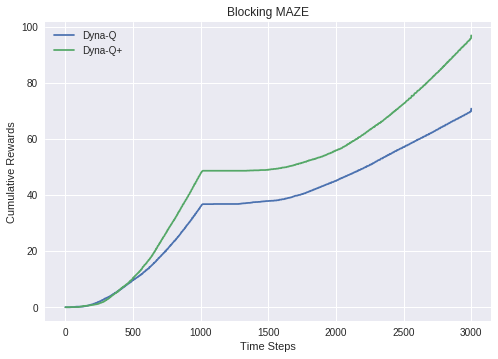

In [16]:
blockingMAZE()

### The above graph shows that after 1000 time steps when the environment is changed, (the shorter path is opened and the longer one is blocked), the graphs become flat, which indicates the period when agents receive no rewards as they still try to get through the learned longer path and dont try to get into recently opened path. After a while they explore the new opened path and new optimal behavior. 

## Shortcut Maze

Intially, there is a path from start($S$) to goal ($G$) as shown in Pattern 1. Here $0$ denotes mvable space and $1$ is obstacle. After $3000$ time steps a shorter path is opened along the right side without disturbing the path on left side as shown in Pattern 2.


** Pattern 1**

|0|0|0|0|0|0|0|0|0|
--|--
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|
|0|1|1|1|1|1|1|1|1|
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|

** Pattern 2**

|0|0|0|0|0|0|0|0|0|
--|--
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|
|0|1|1|1|1|1|1|1|0|
|0|0|0|0|0|0|0|0|0|
|0|0|0|0|0|0|0|0|0|

**The below graph shows the cumulative reward for Dyna Q and enhanced Dyna Q+ agents for time steps.
The average is considered over 20 runs to get smooth plot.**

---
The final parameter value set for the below graph is as below:

 Parameter | Final Value 
---|---
$ \epsilon$ |$0.1$  
$\gamma$ | $0.95$ 
$\alpha$ | $0.7$ 
$ \kappa$ | $1e-3$
Runs| $5$
Planning Steps| $50$


[[  0.    0.    0.  ... 299.6 299.8 300.8]
 [  0.    0.    0.  ... 353.  353.  354. ]]


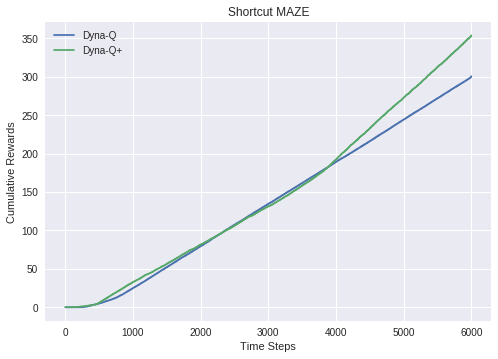

In [22]:
shortcutMAZE()

### The above graph shows that after 3000 time steps when the environment is changed, (the other shorter path is opened) Dyna Q agent never realizes about this shorter path. In fact, it never realized that it existed. Its model said that there was no shortcut, so the more it planned (planning steps increased to 50), the less likely it was to step to the right and discover it. Even with an $\epsilon$ -greedy policy, it is very unlikely that an agent will take so many exploratory actions as to discover the shortcut.

 
## How is the above deterministic model update in Dyna-Q related to Lin’s experience replay ? 

**Answer : **

> 

```
An experience is a quadruple, (x, a, y, r), meaning that the execution of an action a in a state x results in a new state y and reward r. A lesson is a temporal sequence of experiences starting from an initial state to a final state, where the goal may or may not be achieved. 

>Similarly, the deterministic model update in our Dyna-Q algorithm, which is step 5) Model(S,A) <- R,S’ also talks about the same parameters, say state S and action A leads us to next state S’ with reward R. 

>By experience replay, the learning agent simply remembers its past experiences and repeatedly presents the experiences to its learning algorithm as if the agent experienced again and again what it had experienced before. Similarly, our deterministic model update in Dyna-Q helps us remembering similar sequence of experiences from the corresponding states to converge quickly through planning and learning. 

>For Dyna-Q, deterministic model is obtained  by sampling past experiences (based on actions and states). In short, the collection of past experiences is a model, which represents  not only explicitly the environment's input-output patterns but also implicitly the probability distributions of multiple outcomes of actions. This characteristics are truly relevant to experience replay as it is also basically learning from past experiences.


```





